In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import cv2

In [2]:
import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### Tensorflow GPU Setup

In [5]:
# See the computing capability of the current GPU
# 3.5 and above is required
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [6]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0']


In [10]:
train_files = []

mask_files = glob('lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

print(train_files[:10])
print(mask_files[:10])
print(train_files)

['lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_10.tif', 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_11.tif', 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_12.tif', 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_13.tif', 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_14.tif', 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_15.tif', 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_16.tif', 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_17.tif', 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_18.tif', 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_19.tif']
['lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_10_mask.tif', 'lgg-mri-segmentation/kaggle_3m\\TCG

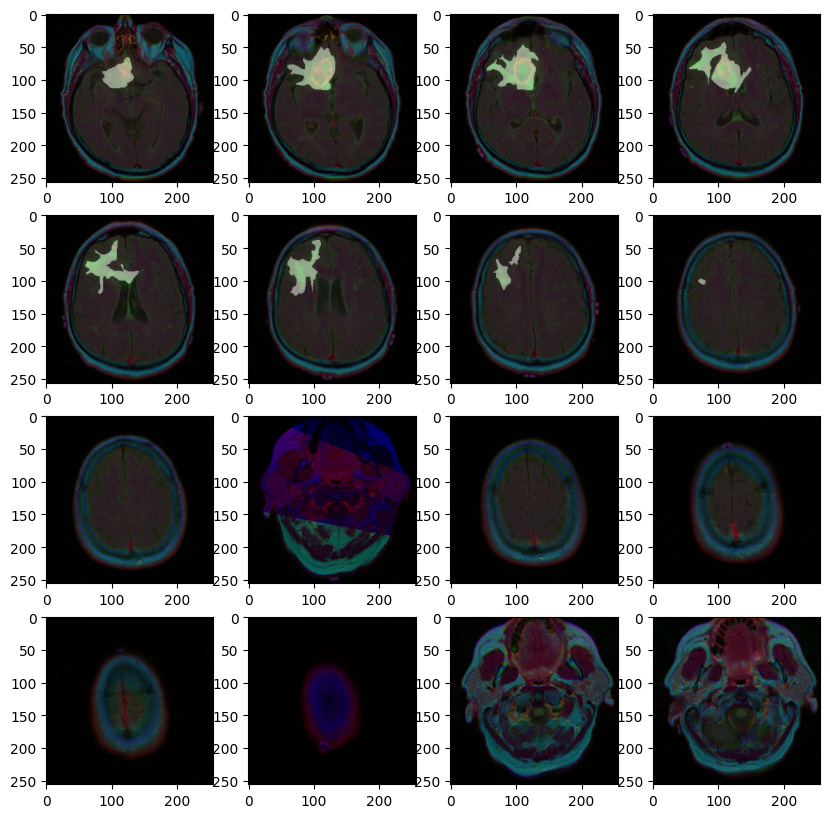

In [12]:
fig = plt.figure(figsize=(10, 10))
for i in range (1, 17):
    fig.add_subplot(4, 4, i)
    img = cv2.imread(train_files[i])
    msk = cv2.imread(mask_files[i])

    plt.imshow(img)
    plt.imshow(msk, alpha=0.4)
plt.show()

In [13]:
from sklearn.model_selection import train_test_split

# Each image file corresponds to its mask file
df = pd.DataFrame(data={"filename": train_files, 'mask': mask_files})

df_train, df_test = train_test_split(df, test_size = 0.1)
df_train, df_val = train_test_split(df_train, test_size = 0.2)
print(df_train.values.shape)
print(df_test.values.shape)
print(df_val.values.shape)

(2828, 2)
(393, 2)
(708, 2)


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def train_generator(data_frame, batch_size, aug_dict,
                   image_color_mode = "rgb",
                   mask_color_mode = "grayscale",
                   image_save_prefix = "image",
                   mask_save_prefix = "mask",
                   save_to_dir = None,
                   target_size = (256, 256),
                   seed = 1):
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix = image_save_prefix,
        seed = seed
    )

    mask_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix = mask_save_prefix,
        seed = seed
    )

    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img, mask)



def adjust_data(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return (img, mask)

In [15]:
# x: number of pixels in the predicted mask
# y: number of pixels in the ground truth mask
"""
    x_flat = x.flatten()
    y_flat = y.flatten()
    intersection = np.sum(y_flat, x_flat)
    intersection_sum = 2.0 * np.sum(intersection) + smooth

    x_sum = np.sum(x_flat)
    y_sum = np.sum(y_flat)
    union = x_sum + y_sum + smooth

    dice_coef = intersection_sum / union
    dice_coef_loss = -dice_coef
"""
from tensorflow.keras import backend as K

def dice_coefficient_loss(x, y, smooth=1e-6):
    y_truef=K.flatten(y)
    y_predf=K.flatten(x)
    And=K.sum(y_truef* y_predf)
    return -((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

In [16]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
IMAGE_CHANNELS = 3

def unet(input_size=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)):
    inputs = Input(input_size)

    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [17]:
model = unet()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape            ┃        Param # ┃ Connected to             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)    │ (None, 256, 256, 3)     │              0 │ -                        │
├─────────────────────────────┼─────────────────────────┼────────────────┼──────────────────────────┤
│ conv2d (Conv2D)             │ (None, 256, 256, 64)    │          1,792 │ input_layer[0][0]        │
├─────────────────────────────┼─────────────────────────┼────────────────┼──────────────────────────┤
│ activation (Activation)     │ (None, 256, 256, 64)    │              0 │ conv2d[0][0]             │
├─────────────────────────────┼─────────────────────────┼────────────────┼──────────────────────────┤
│ conv2d_1 (Conv2D)           │ (None, 256, 256, 64)    │         36,928 │ activation[0][0]         │
├─────────────────────────────┼─────────────────────────┼────────────────┼──────────────────────────┤
│ batch_normalization         │ (None, 256, 256, 64)    │            256 │ conv2d_1[0][0]           │
│ (BatchNormalization)        │                         │                │                          │
├─────────────────────────────┼─────────────────────────┼────────────────┼──────────────────────────┤
│ activation_1 (Activation)   │ (None, 256, 256, 64)    │              0 │ batch_normalization[0][… │
├─────────────────────────────┼─────────────────────────┼────────────────┼──────────────────────────┤
│ max_pooling2d               │ (None, 128, 128, 64)    │              0 │ activation_1[0][0]       │
│ (MaxPooling2D)              │                         │                │                          │
├─────────────────────────────┼─────────────────────────┼────────────────┼──────────────────────────┤
│ conv2d_2 (Conv2D)           │ (None, 128, 128, 128)   │         73,856 │ max_pooling2d[0][0]      │
├─────────────────────────────┼─────────────────────────┼────────────────┼──────────────────────────┤
│ activation_2 (Activation)   │ (None, 128, 128, 128)   │              0 │ conv2d_2[0][0]           │
├─────────────────────────────┼─────────────────────────┼────────────────┼──────────────────────────┤
│ conv2d_3 (Conv2D)           │ (None, 128, 128, 128)   │        147,584 │ activation_2[0][0]       │
├─────────────────────────────┼─────────────────────────┼────────────────┼──────────────────────────┤
│ batch_normalization_1       │ (None, 128, 128, 128)   │            512 │ conv2d_3[0][0]           │
│ (BatchNormalization)        │                         │                │                          │
├─────────────────────────────┼─────────────────────────┼────────────────┼──────────────────────────┤
│ activation_3 (Activation)   │ (None, 128, 128, 128)   │              0 │ batch_normalization_1[0… │
├─────────────────────────────┼─────────────────────────┼────────────────┼──────────────────────────┤
│ max_pooling2d_1             │ (None, 64, 64, 128)     │              0 │ activation_3[0][0]       │
│ (MaxPooling2D)              │                         │                │                          │
├─────────────────────────────┼─────────────────────────┼────────────────┼──────────────────────────┤
│ conv2d_4 (Conv2D)           │ (None, 64, 64, 256)     │        295,168 │ max_pooling2d_1[0][0]    │
├─────────────────────────────┼─────────────────────────┼────────────────┼──────────────────────────┤
│ activation_4 (Activation)   │ (None, 64, 64, 256)     │              0 │ conv2d_4[0][0]           │
├─────────────────────────────┼─────────────────────────┼────────────────┼──────────────────────────┤
│ conv2d_5 (Conv2D)           │ (None, 64, 64, 256)     │        590,080 │ activation_4[0][0]       │
├─────────────────────────────┼─────────────────────────┼────────────────┼──────────────────────────┤
│ batch_normalization_

 Total params: 31,043,521 (118.42 MB)

 Trainable params: 31,037,633 (118.40 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [18]:
im_height = 256
im_width = 256
color_channels = 3

In [19]:
EPOCHS = 150
BATCH_SIZE = 32
learning_rate = 1e-4

In [20]:
len(df_train)

2828

In [21]:
import math

train_generator_arguments = dict(rotation_range=0.2,
                                width_shift_range=0.05,
                                height_shift_range=0.05,
                                shear_range=0.05,
                                zoom_range=0.05,
                                horizontal_flip=True,
                                fill_mode='nearest')

train_gen = train_generator(df_train,
                            BATCH_SIZE,
                            train_generator_arguments,
                            target_size=(im_height, im_width))

val_gen = train_generator(df_val,
                          BATCH_SIZE,
                          dict(),
                          target_size=(im_height, im_width))

model = unet(input_size=(im_height, im_width, color_channels))

decay_rate = learning_rate / EPOCHS

opt = Adam(learning_rate=learning_rate,
           beta_1=0.9,
           beta_2=0.999,
           # epsilon=None,
           weight_decay=decay_rate,
           amsgrad=False)

model.compile(optimizer=opt,
              loss=dice_coefficient_loss,
              metrics=["binary_accuracy"])

callbacks = [ModelCheckpoint('unet_brain_mri_seg.keras', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch= math.floor(len(df_train) / BATCH_SIZE),
                    epochs = EPOCHS,
                    callbacks = callbacks,
                    validation_data = val_gen,
                    validation_steps = len(df_val) / BATCH_SIZE)

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/150


KeyboardInterrupt: 